# Quaternions and Key Bindings: Simple 3D Visualization in Matplotlib

*This notebook was originally a blog post at*
[*Pythonic Perambulations*](http://jakevdp.github.com/blog/2012/11/24/simple-3d-visualization-in-matplotlib/)
*by Jake Vanderplas*

<!-- PELICAN_BEGIN_SUMMARY -->
Matplotlib is a powerful framework, but its 3D capabilities still have
a lot of room to grow. The [mplot3d](http://matplotlib.org/mpl_toolkits/mplot3d/index.html)
toolkit allows for several kinds of 3D plotting, but the ability to create
and rotate solid 3D objects is hindered by the inflexibility of the ``zorder`` attribute:
because it is not updated when the view is rotated, things in the "back" will cover
things in the "front", obscuring them and leading to very unnatural-looking results.

I decided to see if I could create a simple script that addresses this.  Though it would
be possible to use the built-in ``mplot3d`` architecture to take care of rotating and
projecting the points, I decided to do it from scratch for the sake of my own education.

We'll step through it below: by the end of this post we will have created a 3D viewer in
matplotlib which I think is quite nice.
<!-- PELICAN_END_SUMMARY -->

## Rotations in 3D: Quaternions

The first step to creating an interactive 3D object is to decide on a
representation for the orientation of the object.  ``mplot3d`` uses
azimuthal and elevation angles: these are the familiar $\theta$ and $\phi$
of spherical coordinate systems.  While this is a common system, it has the 
disadvantage that things get a little funky near the poles.

Another common framework for mathematical representation of solid-body rotations
is a rotation matrix.  This is nice because multiple rotations can be 
composed quickly, but extracting axis and angle information can require
matrix decompositions that are relatively expensive.

Finally, perhaps the best option is the use of
[quaternions](http://en.wikipedia.org/wiki/Quaternion),
four-dimensional generalizations of complex numbers which can be used to compactly
[represent 3D rotations](http://en.wikipedia.org/wiki/Quaternions_and_spatial_rotation).
A friend who works in the video game industry (in particular the *Halo* series)
told me that quaternions are what the industry generally prefers in many situations:
they are compact, fast to compose, and very powerful.
On top of that, they're generally cool enough that I wanted
an excuse to play around with them a bit.

There have been a few attempts to include quaternions natively in the scipy universe, but
none have stuck.  It's a shame, because it would be a very useful feature. In particular,
In particular, I'd love to see something happen with the quaternion dtype, discussed
[here](http://mail.scipy.org/pipermail/numpy-discussion/2011-July/057675.html)
on the numpy-dev email list. It looks promising, but has not yet been included in numpy.

With the lack of available implementations, I decided to write a basic quaternion class
which implements the functionality I need: multiplication of quaternions, and tranformation
to and from axis-angle representation:

In [1]:
import numpy as np

class Quaternion:
    """Quaternions for 3D rotations"""
    def __init__(self, x):
        self.x = np.asarray(x, dtype=float)
        
    @classmethod
    def from_v_theta(cls, v, theta):
        """
        Construct quaternion from unit vector v and rotation angle theta
        """
        theta = np.asarray(theta)
        v = np.asarray(v)
        
        s = np.sin(0.5 * theta)
        c = np.cos(0.5 * theta)
        vnrm = np.sqrt(np.sum(v * v))

        q = np.concatenate([[c], s * v / vnrm])
        return cls(q)

    def __repr__(self):
        return "Quaternion:\n" + self.x.__repr__()

    def __mul__(self, other):
        # multiplication of two quaternions.
        prod = self.x[:, None] * other.x

        return self.__class__([(prod[0, 0] - prod[1, 1]
                                 - prod[2, 2] - prod[3, 3]),
                                (prod[0, 1] + prod[1, 0]
                                 + prod[2, 3] - prod[3, 2]),
                                (prod[0, 2] - prod[1, 3]
                                 + prod[2, 0] + prod[3, 1]),
                                (prod[0, 3] + prod[1, 2]
                                 - prod[2, 1] + prod[3, 0])])

    def as_v_theta(self):
        """Return the v, theta equivalent of the (normalized) quaternion"""
        # compute theta
        norm = np.sqrt((self.x ** 2).sum(0))
        theta = 2 * np.arccos(self.x[0] / norm)

        # compute the unit vector
        v = np.array(self.x[1:], order='F', copy=True)
        v /= np.sqrt(np.sum(v ** 2, 0))

        return v, theta

    def as_rotation_matrix(self):
        """Return the rotation matrix of the (normalized) quaternion"""
        v, theta = self.as_v_theta()
        c = np.cos(theta)
        s = np.sin(theta)

        return np.array([[v[0] * v[0] * (1. - c) + c,
                          v[0] * v[1] * (1. - c) - v[2] * s,
                          v[0] * v[2] * (1. - c) + v[1] * s],
                         [v[1] * v[0] * (1. - c) + v[2] * s,
                          v[1] * v[1] * (1. - c) + c,
                          v[1] * v[2] * (1. - c) - v[0] * s],
                         [v[2] * v[0] * (1. - c) - v[1] * s,
                          v[2] * v[1] * (1. - c) + v[0] * s,
                          v[2] * v[2] * (1. - c) + c]])

The mathematics of quaternions (and the use of unit quaternions to represent rotations) is fascinating in itself, but the details beyond this simple implementation are too much for this short post.  I'd suggest
[this paper](http://courses.cms.caltech.edu/cs171/quatut.pdf) for a more complete introduction.

## Simple 3D object: A Cube

Let's use these quaternions to draw a cube in matplotlib.

A cube is made of six faces, each rotated from the other in multiples of ninety degrees.
With this in mind, we'll define a fiducial face, and six rotators which will put the
face in place.

One we have these, we can concatenate a viewing angle to all six, project the results,
and display them as polygons on an axes.  An important piece here is to get the ``zorder``
attribute correct, so that faces in the back do not cover faces in the front.  We'll use
the z-coordinate from the projection to do this correctly.

For later use, we'll do this all within a class derived from ``plt.Axes``, and make it
so that the set of polygons can be updated if needed:

In [2]:
# don't use %pylab inline, because we want to interact with plots below.
%pylab

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


In [3]:
class CubeAxes(plt.Axes):
    """An Axes for displaying a 3D cube"""
    # fiducial face is perpendicular to z at z=+1
    one_face = np.array([[1, 1, 1], [1, -1, 1], [-1, -1, 1], [-1, 1, 1], [1, 1, 1]])

    # construct six rotators for the face
    x, y, z = np.eye(3)
    rots = [Quaternion.from_v_theta(x, theta) for theta in (np.pi / 2, -np.pi / 2)]
    rots += [Quaternion.from_v_theta(y, theta) for theta in (np.pi / 2, -np.pi / 2)]
    rots += [Quaternion.from_v_theta(y, theta) for theta in (np.pi, 0)]
    
    # colors of the faces
    colors = ['blue', 'green', 'white', 'yellow', 'orange', 'red']
    
    def __init__(self, fig, rect=[0, 0, 1, 1], *args, **kwargs):
        # We want to set a few of the arguments
        kwargs.update(dict(xlim=(-2.5, 2.5), ylim=(-2.5, 2.5), frameon=False,
                           xticks=[], yticks=[], aspect='equal'))
        super(CubeAxes, self).__init__(fig, rect, *args, **kwargs)
        self.xaxis.set_major_formatter(plt.NullFormatter())
        self.yaxis.set_major_formatter(plt.NullFormatter())
        
        # define the current rotation
        self.current_rot = Quaternion.from_v_theta((1, 1, 0), np.pi / 6)
        
    
    def draw_cube(self):
        """draw a cube rotated by theta around the given vector"""
        # rotate the six faces
        Rs = [(self.current_rot * rot).as_rotation_matrix() for rot in self.rots]
        faces = [np.dot(self.one_face, R.T) for R in Rs]
        
        # project the faces: we'll use the z coordinate
        # for the z-order
        faces_proj = [face[:, :2] for face in faces]
        zorder = [face[:4, 2].sum() for face in faces]
        
        # create the polygons if needed.
        # if they're already drawn, then update them
        if not hasattr(self, '_polys'):
            self._polys = [plt.Polygon(faces_proj[i], fc=self.colors[i],
                                       alpha=0.9, zorder=zorder[i])
                           for i in range(6)]
            for i in range(6):
                self.add_patch(self._polys[i])
        else:
            for i in range(6):
                self._polys[i].set_xy(faces_proj[i])
                self._polys[i].set_zorder(zorder[i])
                
        self.figure.canvas.draw()

With this in place, we can draw the cube as follows:

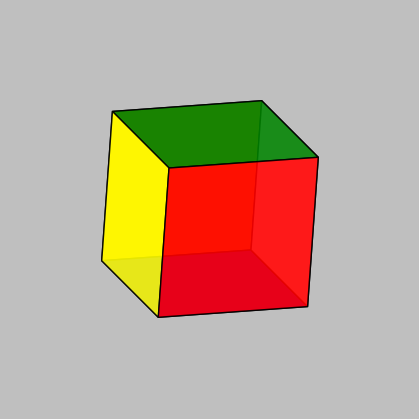

In [4]:
fig = plt.figure(figsize=(4, 4))
ax = CubeAxes(fig)
fig.add_axes(ax)
ax.draw_cube()
display(fig)

## Events and Callbacks

Now comes the fun part.  We can add events and callbacks to the axes
which will allow us to manipulate the projection by clicking and
dragging on the figure.

We need to add callbacks to the axes: we'll do this in the construction
of the class using the ``mpl_connect`` method of the canvas. There are
several types of callback events that can be hooked:  they can be found
by typing ``plt.connect?`` and seeing the doc-string:

In [5]:
plt.connect?

The available options are:

- ``'button_press_event'``
- ``'button_release_event'``
- ``'draw_event'``
- ``'key_press_event'``
- ``'key_release_event'``
- ``'motion_notify_event'``
- ``'pick_event'``
- ``'resize_event'``
- ``'scroll_event'``
- ``'figure_enter_event'``
- ``'figure_leave_event'``
- ``'axes_enter_event'``
- ``'axes_leave_event'``
- ``'close_event'``

Each of these can be connected to a function that performs some operation
when those events happen.  Below, we'll use the button events, the motion
event, and the key press event to create an interactive 3D plot.
To be as concise as possible, we'll derive from the class we created above:

In [6]:
class CubeAxesInteractive(CubeAxes):
    """An Axes for displaying an Interactive 3D cube"""
    def __init__(self, *args, **kwargs):
        super(CubeAxesInteractive, self).__init__(*args, **kwargs)
        
        # define axes for Up/Down motion and Left/Right motion
        self._v_LR = (0, 1, 0)
        self._v_UD = (-1, 0, 0)
        self._active = False
        self._xy = None

        # connect some GUI events
        self.figure.canvas.mpl_connect('button_press_event',
                                       self._mouse_press)
        self.figure.canvas.mpl_connect('button_release_event',
                                       self._mouse_release)
        self.figure.canvas.mpl_connect('motion_notify_event',
                                       self._mouse_motion)
        self.figure.canvas.mpl_connect('key_press_event',
                                       self._key_press)
        self.figure.canvas.mpl_connect('key_release_event',
                                       self._key_release)
        
        self.figure.text(0.05, 0.05, ("Click and Drag to Move\n"
                                    "Hold shift key to adjust rotation"))

    #----------------------------------------------------------
    # when the shift button is down, change the rotation axis
    # of left-right movement
    def _key_press(self, event):
        """Handler for key press events"""
        if event.key == 'shift':
            self._v_LR = (0, 0, -1)

    def _key_release(self, event):
        """Handler for key release event"""
        if event.key == 'shift':
            self._v_LR = (0, 1, 0)

    #----------------------------------------------------------
    # while the mouse button is pressed, set state to "active"
    # so that motion event will rotate the plot
    def _mouse_press(self, event):
        """Handler for mouse button press"""
        if event.button == 1:
            self._active = True
            self._xy = (event.x, event.y)

    def _mouse_release(self, event):
        """Handler for mouse button release"""
        if event.button == 1:
            self._active = False
            self._xy = None

    def _mouse_motion(self, event):
        """Handler for mouse motion"""
        if self._active:
            dx = event.x - self._xy[0]
            dy = event.y - self._xy[1]
            self._xy = (event.x, event.y)
            
            rot1 = Quaternion.from_v_theta(self._v_UD, 0.01 * dy)
            rot2 = Quaternion.from_v_theta(self._v_LR, 0.01 * dx)

            self.current_rot = (rot2 * rot1 * self.current_rot)
            self.draw_cube()

To see the interactive cube, run the following code (interactivity will not work
within the web browser)  You should be able to use the mouse to change the orientation
of the cube, and hold the shift key to change the type of rotation used.

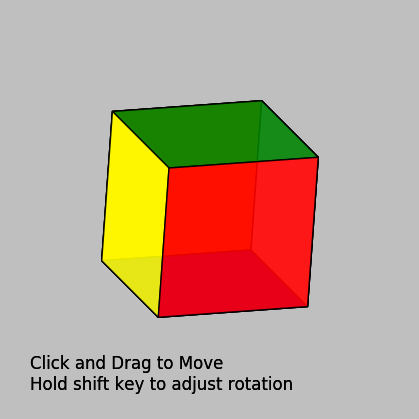

In [9]:
# fig = plt.figure(figsize=(4, 4))
ax = CubeAxesInteractive(fig)
fig.add_axes(ax)
ax.draw_cube()
display(fig)


Note that the image above is a static view:  To experience
the interactivity, [download the notebook](http://jakevdp.github.com/downloads/notebooks/3DCube.ipynb)
and run it on your own machine.

## Conclusion

If you're anything like me, your mind is probably spinning with all the
possibilities of these tools.  My eventual goal is to make a fully
functional Rubik's cube simulator using these sorts of techniques.  It
will take some thinking, but I think it can be done, and it would be a
very cool demonstration of Matplotlib's capabilities!
I'll be working on this with David Hogg over at the
[Magic Cube github repository](https://github.com/jakevdp/MagicCube):
much of the simple script
shown above was adapted from code I first wrote there.

The possibilities are endless, and I hope you have fun with these tools!

This post was written entirely in an IPython Notebook: the notebook file is available for
download [here](http://jakevdp.github.com/downloads/notebooks/3DCube.ipynb).
For more information on blogging with notebooks in octopress, see my
[previous post](http://jakevdp.github.com/blog/2012/10/04/blogging-with-ipython/)
on the subject.